Main Code

Code for generating comparisons

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

def generate_comparisons(true_r, true_beta, M, N, K):
    """
    Generates synthetic pairwise comparisons with constraints:
    - true_r ∈ [0, 1]
    - true_beta ∈ [0, 1]
    """
    comparisons = []
    for _ in range(M):
        k = np.random.randint(K)  # Worker index
        a, b = np.random.choice(N, 2, replace=False)

        # Compute probability using constrained rewards and beta
        reward_diff = true_r[a] - true_r[b]
        prob = 1 / (1 + np.exp(-true_beta[k] * reward_diff))

        if np.random.rand() < prob:
            comparisons.append((a, b, k))
        else:
            comparisons.append((b, a, k))
    return comparisons

In [2]:
def metrics(true_r, true_beta, estimated_r, estimated_beta):
  rmse_r = np.sqrt(np.mean((true_r - estimated_r)**2))
  rmse_beta = np.sqrt(np.mean((true_beta - estimated_beta)**2))
  # print(f"RMSE for Item Rewards: {rmse_r}")
  return rmse_r, rmse_beta

EM Code

Experiments by varying:
1. Number of items.
2. Number of comparisons.
3. Number of workers.

Metrics:
1. Accuracy
2. Comparison with Majority vote
3. RMSE between competence and reward vector

In [3]:
def get_original_label(comparisons):
  original_labels = []
  for w_i, l_i, _ in comparisons:
    w_i = int(w_i)
    l_i = int(l_i)
    if true_r[w_i] > true_r[l_i]:
        original_labels.append(1)
    else:
        original_labels.append(0)
  return original_labels

In [4]:
def estimate_labels(estimated_r1):
  estimated_labels = []
  for w_i, l_i, _ in comparisons:
    w_i = int(w_i)
    l_i = int(l_i)
    if true_r[w_i] > true_r[l_i]:
      if estimated_r1[w_i] > estimated_r1[l_i]:
        estimated_labels.append(1)
      else:
        estimated_labels.append(0)
    else:
      if true_r[w_i] < true_r[l_i]:
        if estimated_r1[w_i] < estimated_r1[l_i]:
          estimated_labels.append(1)
        else:
          estimated_labels.append(0)
  return estimated_labels

In [8]:
import torch
from tqdm import tqdm

class PolyaGammaEMGPU:
    def __init__(self, num_items, num_workers, max_iter=500, epsilon=1e-4, device='cuda'):
        self.num_items = num_items
        self.num_workers = num_workers
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.device = device

        # Initialize parameters with identifiability constraints
        self.r = torch.randn(num_items, device=device)
        self.r -= self.r.mean()
        self.beta = torch.empty(num_workers, device=device).uniform_(0.1, 0.9)
        
        # Precompute constants
        self.ones = torch.ones(1, device=device)
        self.half = torch.tensor(0.5, device=device)
        self.eps = torch.tensor(1e-10, device=device)

    def fit(self, comparisons):
        # Convert comparisons to tensor and move to device
        comp_tensor = torch.tensor(comparisons, dtype=torch.long, device=self.device)
        w = comp_tensor[:, 0]
        l = comp_tensor[:, 1]
        k = comp_tensor[:, 2]
        
        prev_r = self.r.clone()
        prev_beta = self.beta.clone()

        for _ in tqdm(range(self.max_iter)):
            # E-step: Vectorized PG expectations
            x = self.beta[k] * (self.r[w] - self.r[l])
            ew = torch.where(
                x.abs() < 1e-8,
                0.25 - (x**2)/48.0,
                torch.tanh(x/2) / (2*x)
            )

            # M-step: Vectorized updates
            self._update_rewards(w, l, k, ew)
            self._update_competencies(w, l, k, ew)

            # Enforce constraints
            self.r -= self.r.mean()
            self.beta = torch.clamp(self.beta, 1e-10, 1-1e-10)

            # Check convergence
            if self._check_convergence(prev_r, prev_beta):
                break
            prev_r.copy_(self.r)
            prev_beta.copy_(self.beta)

        return self.r.cpu().numpy(), self.beta.cpu().numpy()

    def _update_rewards(self, w, l, k, ew):
        beta_k = self.beta[k]
        beta_sq = beta_k ** 2
        
        # Vectorized numerator/denominator updates
        numerator = torch.zeros_like(self.r)
        denominator = torch.zeros_like(self.r)
        
        # Winning items
        numerator.scatter_add_(0, w, 0.5 * ew)
        denominator.scatter_add_(0, w, ew * beta_sq)
        
        # Losing items
        numerator.scatter_add_(0, l, -0.5 * ew)
        denominator.scatter_add_(0, l, ew * beta_sq)

        # Update rewards with stability
        self.r = numerator / torch.clamp(denominator, min=1e-10)

    def _update_competencies(self, w, l, k, ew):
        delta = self.r[w] - self.r[l]
        beta_k_old = torch.clamp(self.beta[k], min=1e-10)
        factor = 0.5 / beta_k_old
        
        # Vectorized updates
        numerator = torch.zeros_like(self.beta)
        denominator = torch.zeros_like(self.beta)
        
        numerator.scatter_add_(0, k, ew * factor * delta)
        denominator.scatter_add_(0, k, ew * delta ** 2)

        # Update only workers with comparisons
        mask = denominator > 1e-10
        self.beta[mask] = numerator[mask] / denominator[mask]

    def _check_convergence(self, prev_r, prev_beta):
        r_diff = torch.norm(self.r - prev_r)
        beta_diff = torch.norm(self.beta - prev_beta)
        return r_diff < self.epsilon and beta_diff < self.epsilon

In [6]:
!nvidia-smi

Mon May  5 07:20:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:17:00.0 Off |                    0 |
| N/A   69C    P0             202W / 300W |  66195MiB / 81920MiB |     69%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
def get_original_label(comparisons):
  original_labels = []
  for w_i, l_i, _ in comparisons:
    w_i = int(w_i)
    l_i = int(l_i)
    if true_r[w_i] > true_r[l_i]:
        original_labels.append(1)
    else:
        original_labels.append(0)
  return original_labels

In [11]:
def estimate_labels(estimated_r1):
  estimated_labels = []
  for w_i, l_i, _ in comparisons:
    w_i = int(w_i)
    l_i = int(l_i)
    if true_r[w_i] > true_r[l_i]:
      if estimated_r1[w_i] > estimated_r1[l_i]:
        estimated_labels.append(1)
      else:
        estimated_labels.append(0)
    else:
      if true_r[w_i] < true_r[l_i]:
        if estimated_r1[w_i] < estimated_r1[l_i]:
          estimated_labels.append(1)
        else:
          estimated_labels.append(0)
  return estimated_labels

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import defaultdict

# Set seed for reproducibility
np.random.seed(42)
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]
# N_array = [50]
# K_array = [6]

scores_dict = {}
rmse_r_array_dict = defaultdict(lambda:[])
rmse_beta_array_dict = defaultdict(lambda:[])
for N, K in zip(N_array, K_array):
    # True parameters (constrained to [0, 1])
    true_r = np.random.rand(N)     # Item rewards (0 = worst, 1 = best)
    true_r = true_r - true_r.mean()
    true_beta = np.random.rand(K)          # Worker competencies (0 = random, 1 = perfect)
    M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
    # M_array = [60000]
    accuracy_scores = []
    original_accuracy_scores = []
    
    rmse_r_array = []
    rmse_beta_array = []

    for m in M_array:
        comparisons = generate_comparisons(true_r, true_beta, m, N, K)
        # estimated_r3, estimated_beta3, history3 = model.fit(comparisons)
        model = PolyaGammaEMGPU(N, K, device=device)
        r_est, b_est = model.fit(comparisons)
        
        r_est = 1 / (1 + np.exp(-r_est))
        r_est = r_est - r_est.mean()
        
        rmse_r3, rmse_beta3 = metrics(true_r, true_beta, r_est, b_est)
#           print(rmse_r3)
#           print(rmse_beta3)
        true_labels = [1]*len(comparisons)
        estimated_labels = estimate_labels(r_est)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, estimated_labels)
        accuracy_scores.append(accuracy)
        rmse_r_array.append(rmse_r3)
        rmse_beta_array.append(rmse_beta3)
#         print(accuracy)


        original_labels = get_original_label(comparisons)
        original_accuracy = accuracy_score(true_labels, original_labels)
#         print(original_accuracy)
        print(f"N={N}, K={K}, m={m}: EM={accuracy:.4f}, Original={original_accuracy:.4f}")
        original_accuracy_scores.append(original_accuracy)
    
    
    rmse_r_array_dict[str(N)+"_"+str(K)] = rmse_r_array
    rmse_beta_array_dict[str(N)+"_"+str(K)] = rmse_beta_array
    print(accuracy_scores)
    scores_dict[f'{N}_{K}'] = {
        "our": accuracy_scores,
        "original": original_accuracy_scores
    }

  2%|██▉                                                                                                                                              | 10/500 [00:00<00:02, 213.48it/s]


N=10, K=2, m=100: EM=0.5100, Original=0.5400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 254.09it/s]


N=10, K=2, m=1000: EM=0.7140, Original=0.5510


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 260.04it/s]


N=10, K=2, m=5000: EM=0.9372, Original=0.5478


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.50it/s]


N=10, K=2, m=10000: EM=0.9171, Original=0.5489


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 270.71it/s]


N=10, K=2, m=20000: EM=0.9566, Original=0.5454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 240.15it/s]


N=10, K=2, m=40000: EM=0.9568, Original=0.5474


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 259.91it/s]


N=10, K=2, m=60000: EM=0.9345, Original=0.5432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.66it/s]


N=10, K=2, m=80000: EM=0.9561, Original=0.5468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 216.61it/s]


N=10, K=2, m=100000: EM=0.9771, Original=0.5472
[0.51, 0.714, 0.9372, 0.9171, 0.95655, 0.95685, 0.93455, 0.9561, 0.97711]


 14%|███████████████████▋                                                                                                                             | 68/500 [00:00<00:01, 251.95it/s]


N=50, K=2, m=100: EM=0.6200, Original=0.6100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 288.56it/s]


N=50, K=2, m=1000: EM=0.6990, Original=0.5640


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.29it/s]


N=50, K=2, m=5000: EM=0.8804, Original=0.5806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.47it/s]


N=50, K=2, m=10000: EM=0.8956, Original=0.5708


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 258.41it/s]


N=50, K=2, m=20000: EM=0.9238, Original=0.5740


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.34it/s]


N=50, K=2, m=40000: EM=0.9373, Original=0.5723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 233.13it/s]


N=50, K=2, m=60000: EM=0.9465, Original=0.5711


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 250.10it/s]


N=50, K=2, m=80000: EM=0.9608, Original=0.5743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 213.82it/s]


N=50, K=2, m=100000: EM=0.9580, Original=0.5723
[0.62, 0.699, 0.8804, 0.8956, 0.92385, 0.937325, 0.9465, 0.960775, 0.95801]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 264.99it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=50, K=6, m=100: EM=0.2900, Original=0.6400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.77it/s]


N=50, K=6, m=1000: EM=0.5640, Original=0.5170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.92it/s]


N=50, K=6, m=5000: EM=0.7582, Original=0.5326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.91it/s]


N=50, K=6, m=10000: EM=0.7778, Original=0.5283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 254.34it/s]


N=50, K=6, m=20000: EM=0.8094, Original=0.5272


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 278.61it/s]


N=50, K=6, m=40000: EM=0.9142, Original=0.5359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 241.35it/s]


N=50, K=6, m=60000: EM=0.8837, Original=0.5274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 255.13it/s]


N=50, K=6, m=80000: EM=0.8916, Original=0.5307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.43it/s]


N=50, K=6, m=100000: EM=0.9174, Original=0.5327
[0.29, 0.564, 0.7582, 0.7778, 0.80935, 0.914225, 0.88365, 0.8915875, 0.91745]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 255.40it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=100, K=8, m=100: EM=0.2300, Original=0.5000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 282.36it/s]


N=100, K=8, m=1000: EM=0.6180, Original=0.5310


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 288.19it/s]


N=100, K=8, m=5000: EM=0.7180, Original=0.5368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 257.31it/s]


N=100, K=8, m=10000: EM=0.7381, Original=0.5379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 261.31it/s]


N=100, K=8, m=20000: EM=0.7935, Original=0.5370


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 284.39it/s]


N=100, K=8, m=40000: EM=0.8327, Original=0.5355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 245.13it/s]


N=100, K=8, m=60000: EM=0.8504, Original=0.5379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 256.89it/s]


N=100, K=8, m=80000: EM=0.8887, Original=0.5397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 235.85it/s]


N=100, K=8, m=100000: EM=0.8939, Original=0.5383
[0.23, 0.618, 0.718, 0.7381, 0.7935, 0.83265, 0.85035, 0.888675, 0.89387]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 272.09it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=8, m=100: EM=0.2800, Original=0.5700


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.11it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=8, m=1000: EM=0.0590, Original=0.5340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.90it/s]


N=200, K=8, m=5000: EM=0.6382, Original=0.5264


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.66it/s]


N=200, K=8, m=10000: EM=0.6532, Original=0.5316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 267.36it/s]


N=200, K=8, m=20000: EM=0.7291, Original=0.5311


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 264.38it/s]


N=200, K=8, m=40000: EM=0.7682, Original=0.5330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 241.82it/s]


N=200, K=8, m=60000: EM=0.8265, Original=0.5340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 260.21it/s]


N=200, K=8, m=80000: EM=0.8256, Original=0.5318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 240.69it/s]


N=200, K=8, m=100000: EM=0.8443, Original=0.5362
[0.28, 0.059, 0.6382, 0.6532, 0.72915, 0.768225, 0.8264833333333333, 0.825575, 0.84429]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 290.97it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=100, K=10, m=100: EM=0.4000, Original=0.6100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.67it/s]


N=100, K=10, m=1000: EM=0.6160, Original=0.5470


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 292.88it/s]


N=100, K=10, m=5000: EM=0.7300, Original=0.5546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 273.08it/s]


N=100, K=10, m=10000: EM=0.7406, Original=0.5383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 304.76it/s]


N=100, K=10, m=20000: EM=0.8106, Original=0.5392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 248.09it/s]


N=100, K=10, m=40000: EM=0.8623, Original=0.5419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 242.21it/s]


N=100, K=10, m=60000: EM=0.8808, Original=0.5413


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 271.68it/s]


N=100, K=10, m=80000: EM=0.8999, Original=0.5411


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.02it/s]


N=100, K=10, m=100000: EM=0.8904, Original=0.5394
[0.4, 0.616, 0.73, 0.7406, 0.81065, 0.862275, 0.8808333333333334, 0.8999125, 0.89044]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 284.40it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=10, m=100: EM=0.2800, Original=0.4900


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 274.78it/s]


N=200, K=10, m=1000: EM=0.5990, Original=0.5520


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 249.36it/s]


N=200, K=10, m=5000: EM=0.6810, Original=0.5480


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 259.80it/s]


N=200, K=10, m=10000: EM=0.6798, Original=0.5339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 280.09it/s]


N=200, K=10, m=20000: EM=0.7201, Original=0.5296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 247.84it/s]


N=200, K=10, m=40000: EM=0.7930, Original=0.5373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 267.38it/s]


N=200, K=10, m=60000: EM=0.8324, Original=0.5380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 241.39it/s]


N=200, K=10, m=80000: EM=0.8465, Original=0.5360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 256.41it/s]


N=200, K=10, m=100000: EM=0.8600, Original=0.5359
[0.28, 0.599, 0.681, 0.6798, 0.7201, 0.793025, 0.8323833333333334, 0.8465375, 0.86004]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.99it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=50, m=100: EM=0.3600, Original=0.5400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 256.10it/s]


N=200, K=50, m=1000: EM=0.5770, Original=0.5330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.91it/s]


N=200, K=50, m=5000: EM=0.6572, Original=0.5446


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.28it/s]


N=200, K=50, m=10000: EM=0.7157, Original=0.5432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.54it/s]


N=200, K=50, m=20000: EM=0.7257, Original=0.5369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 258.20it/s]


N=200, K=50, m=40000: EM=0.8120, Original=0.5412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 252.54it/s]


N=200, K=50, m=60000: EM=0.8428, Original=0.5409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 254.89it/s]


N=200, K=50, m=80000: EM=0.8585, Original=0.5412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 235.24it/s]


N=200, K=50, m=100000: EM=0.8570, Original=0.5365
[0.36, 0.577, 0.6572, 0.7157, 0.72565, 0.812, 0.8427666666666667, 0.8584875, 0.85698]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 266.11it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=500, K=50, m=100: EM=0.4500, Original=0.6100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 288.33it/s]
/tmp/ipykernel_82617/2532807540.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=500, K=50, m=1000: EM=0.1500, Original=0.5210


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 271.90it/s]


N=500, K=50, m=5000: EM=0.6114, Original=0.5368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 259.51it/s]


N=500, K=50, m=10000: EM=0.6188, Original=0.5359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 283.67it/s]


N=500, K=50, m=20000: EM=0.6745, Original=0.5360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 288.54it/s]


N=500, K=50, m=40000: EM=0.7325, Original=0.5415


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.06it/s]


N=500, K=50, m=60000: EM=0.7611, Original=0.5377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 256.89it/s]


N=500, K=50, m=80000: EM=0.7869, Original=0.5385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 244.21it/s]


N=500, K=50, m=100000: EM=0.8089, Original=0.5388
[0.45, 0.15, 0.6114, 0.6188, 0.67455, 0.732475, 0.7611333333333333, 0.7868875, 0.80894]


In [15]:
print(rmse_r_array_dict["50_6"])

[0.5056605209532873, 0.2695737437741115, 0.26323843383912576, 0.26507094951109605, 0.2659454494596818, 0.26117802312049454, 0.18127416727715412, 0.2629815980682326, 0.26405861343187664]


In [19]:
print(rmse_beta_array_dict["50_2"])

[0.725890282816873, 0.3063026772748604, 0.6035211752514215, 0.6857517316587606, 0.6083086979891659, 0.4737724132198373, 0.5187392489212114, 0.6556110206242707, 0.5293375056735894]


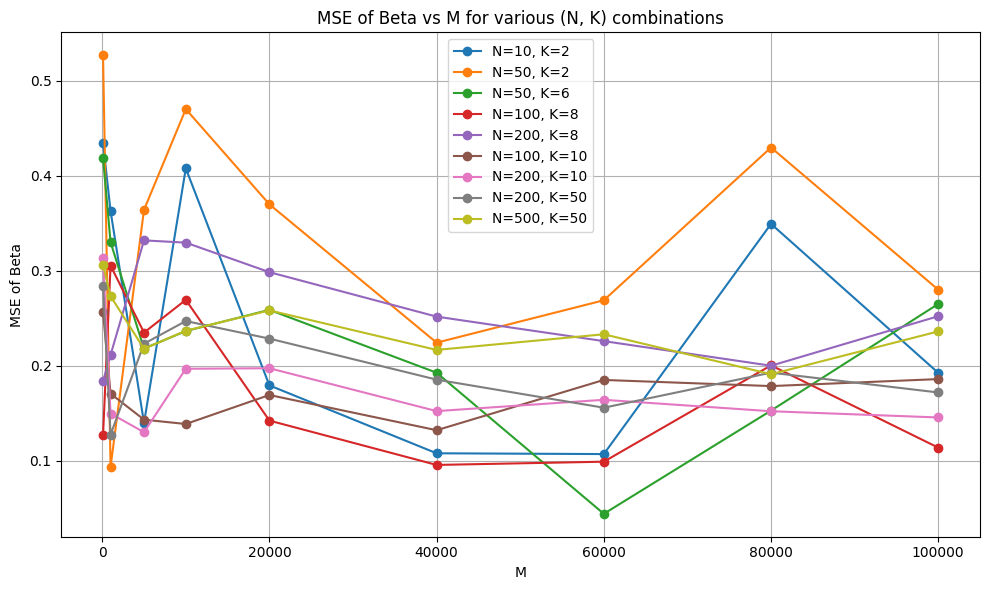

In [21]:
import matplotlib.pyplot as plt
import numpy as np  # needed for squaring the RMSE values

M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]

plt.figure(figsize=(10, 6))

for n, k in zip(N_array, K_array):
    key = f"{n}_{k}"
    rmse_values = rmse_beta_array_dict.get(key)
    if rmse_values is not None:
        mse_values = [v**2 for v in rmse_values]  # square RMSE to get MSE
        plt.plot(M_array, mse_values, marker='o', label=f"N={n}, K={k}")
    else:
        print(f"Warning: No RMSE values found for key {key}")

plt.xlabel("M")
plt.ylabel("MSE of Beta")
plt.title("MSE of Beta vs M for various (N, K) combinations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

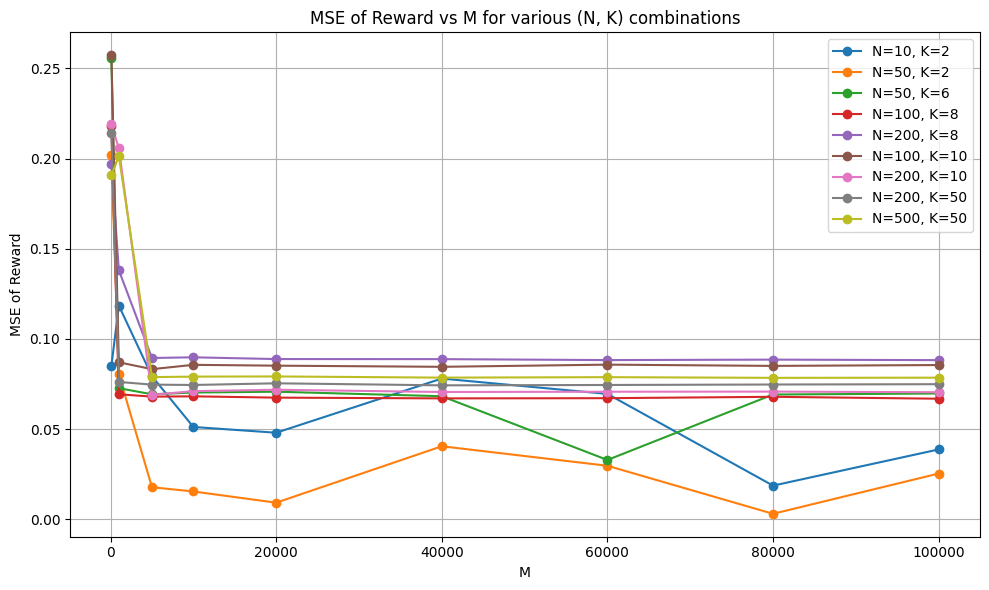

In [25]:
import matplotlib.pyplot as plt
import numpy as np  # needed for squaring the RMSE values

M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]

plt.figure(figsize=(10, 6))

for n, k in zip(N_array, K_array):
    key = f"{n}_{k}"
    rmse_values = rmse_r_array_dict.get(key)
    if rmse_values is not None:
        mse_values = [v**2 for v in rmse_values]  # square RMSE to get MSE
        plt.plot(M_array, mse_values, marker='o', label=f"N={n}, K={k}")
    else:
        print(f"Warning: No RMSE values found for key {key}")

plt.xlabel("M")
plt.ylabel("MSE of Reward")
plt.title("MSE of Reward vs M for various (N, K) combinations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
def metrics1(true_r, true_beta, r_est, b_est):
    """
    Compute the L1 norm (MAE) between true and estimated r and beta.
    
    Parameters:
        true_r (np.ndarray): Ground truth r values
        true_beta (np.ndarray): Ground truth beta values
        r_est (np.ndarray): Estimated r values
        b_est (np.ndarray): Estimated beta values
    
    Returns:
        dict: {
            "L1_r": MAE between true_r and r_est,
            "L1_beta": MAE between true_beta and b_est
        }
    """
    l1_r = np.mean(np.abs(true_r - r_est))
    l1_beta = np.mean(np.abs(true_beta - b_est))
    
    return l1_r, l1_beta

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import defaultdict

# Set seed for reproducibility
np.random.seed(42)
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]
# N_array = [50]
# K_array = [6]

scores_dict = {}
l1_r_array_dict = defaultdict(lambda:[])
l1_beta_array_dict = defaultdict(lambda:[])
for N, K in zip(N_array, K_array):
    # True parameters (constrained to [0, 1])
    true_r = np.random.rand(N)     # Item rewards (0 = worst, 1 = best)
    true_r = true_r - true_r.mean()
    true_beta = np.random.rand(K)          # Worker competencies (0 = random, 1 = perfect)
    M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
    # M_array = [60000]
    accuracy_scores = []
    original_accuracy_scores = []
    
    l1_r_array = []
    l1_beta_array = []

    for m in M_array:
        comparisons = generate_comparisons(true_r, true_beta, m, N, K)
        # estimated_r3, estimated_beta3, history3 = model.fit(comparisons)
        model = PolyaGammaEMGPU(N, K, device=device)
        r_est, b_est = model.fit(comparisons)
        
        r_est = 1 / (1 + np.exp(-r_est))
        r_est = r_est - r_est.mean()
        
        l1_r3, l1_beta3 = metrics1(true_r, true_beta, r_est, b_est)
#           print(rmse_r3)
#           print(rmse_beta3)
        true_labels = [1]*len(comparisons)
        estimated_labels = estimate_labels(r_est)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, estimated_labels)
        accuracy_scores.append(accuracy)
        l1_r_array.append(l1_r3)
        l1_beta_array.append(l1_beta3)
#         print(accuracy)


        original_labels = get_original_label(comparisons)
        original_accuracy = accuracy_score(true_labels, original_labels)
#         print(original_accuracy)
        print(f"N={N}, K={K}, m={m}: EM={accuracy:.4f}, Original={original_accuracy:.4f}")
        original_accuracy_scores.append(original_accuracy)
    
    
    l1_r_array_dict[str(N)+"_"+str(K)] = l1_r_array
    l1_beta_array_dict[str(N)+"_"+str(K)] = l1_beta_array
    print(accuracy_scores)
    scores_dict[f'{N}_{K}'] = {
        "our": accuracy_scores,
        "original": original_accuracy_scores
    }

  3%|███▊                                                                                                                                             | 13/500 [00:00<00:02, 243.48it/s]


N=10, K=2, m=100: EM=0.5100, Original=0.5400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 254.98it/s]


N=10, K=2, m=1000: EM=0.7140, Original=0.5510


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 259.81it/s]


N=10, K=2, m=5000: EM=0.9372, Original=0.5478


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 261.39it/s]


N=10, K=2, m=10000: EM=0.9171, Original=0.5489


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 278.95it/s]


N=10, K=2, m=20000: EM=0.9566, Original=0.5454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 248.23it/s]


N=10, K=2, m=40000: EM=0.9568, Original=0.5474


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.73it/s]


N=10, K=2, m=60000: EM=0.9345, Original=0.5432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 238.16it/s]


N=10, K=2, m=80000: EM=0.9108, Original=0.5468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 237.18it/s]


N=10, K=2, m=100000: EM=0.9771, Original=0.5472
[0.51, 0.714, 0.9372, 0.9171, 0.95655, 0.95685, 0.93455, 0.9108125, 0.97711]


 35%|██████████████████████████████████████████████████▋                                                                                             | 176/500 [00:00<00:01, 300.17it/s]


N=50, K=2, m=100: EM=0.6200, Original=0.6100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 288.09it/s]


N=50, K=2, m=1000: EM=0.6990, Original=0.5640


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.38it/s]


N=50, K=2, m=5000: EM=0.8804, Original=0.5806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 275.03it/s]


N=50, K=2, m=10000: EM=0.8982, Original=0.5708


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 275.54it/s]


N=50, K=2, m=20000: EM=0.9238, Original=0.5740


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 230.96it/s]


N=50, K=2, m=40000: EM=0.9385, Original=0.5723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 244.87it/s]


N=50, K=2, m=60000: EM=0.9465, Original=0.5711


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 223.07it/s]


N=50, K=2, m=80000: EM=0.9608, Original=0.5743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 238.00it/s]


N=50, K=2, m=100000: EM=0.9597, Original=0.5723
[0.62, 0.699, 0.8804, 0.8982, 0.92385, 0.93845, 0.9465, 0.960775, 0.95967]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 289.06it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=50, K=6, m=100: EM=0.1300, Original=0.6400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 248.41it/s]


N=50, K=6, m=1000: EM=0.5640, Original=0.5170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.43it/s]


N=50, K=6, m=5000: EM=0.7582, Original=0.5326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 283.09it/s]


N=50, K=6, m=10000: EM=0.7789, Original=0.5283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.27it/s]


N=50, K=6, m=20000: EM=0.8094, Original=0.5272


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.42it/s]


N=50, K=6, m=40000: EM=0.9141, Original=0.5359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 273.07it/s]


N=50, K=6, m=60000: EM=0.8834, Original=0.5274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 240.77it/s]


N=50, K=6, m=80000: EM=0.8909, Original=0.5307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.56it/s]


N=50, K=6, m=100000: EM=0.9183, Original=0.5327
[0.13, 0.564, 0.7582, 0.7789, 0.80935, 0.91405, 0.8834166666666666, 0.89085, 0.91825]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.02it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=100, K=8, m=100: EM=0.2500, Original=0.5000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.55it/s]


N=100, K=8, m=1000: EM=0.6180, Original=0.5310


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 257.09it/s]


N=100, K=8, m=5000: EM=0.7180, Original=0.5368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 282.61it/s]


N=100, K=8, m=10000: EM=0.7381, Original=0.5379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 260.32it/s]


N=100, K=8, m=20000: EM=0.7937, Original=0.5370


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 265.97it/s]


N=100, K=8, m=40000: EM=0.8332, Original=0.5355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 293.02it/s]


N=100, K=8, m=60000: EM=0.8507, Original=0.5379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 257.68it/s]


N=100, K=8, m=80000: EM=0.8885, Original=0.5397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 260.77it/s]


N=100, K=8, m=100000: EM=0.8930, Original=0.5383
[0.25, 0.618, 0.718, 0.7381, 0.7937, 0.833175, 0.85065, 0.8885125, 0.89296]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.96it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=8, m=100: EM=0.2400, Original=0.5700


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 252.06it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=8, m=1000: EM=0.2920, Original=0.5340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.60it/s]


N=200, K=8, m=5000: EM=0.6382, Original=0.5264


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 276.30it/s]


N=200, K=8, m=10000: EM=0.6533, Original=0.5316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.00it/s]


N=200, K=8, m=20000: EM=0.7291, Original=0.5311


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 284.99it/s]


N=200, K=8, m=40000: EM=0.7683, Original=0.5330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 267.93it/s]


N=200, K=8, m=60000: EM=0.8266, Original=0.5340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 279.27it/s]


N=200, K=8, m=80000: EM=0.8255, Original=0.5318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 239.11it/s]


N=200, K=8, m=100000: EM=0.8446, Original=0.5362
[0.24, 0.292, 0.6382, 0.6533, 0.72915, 0.768275, 0.8266333333333333, 0.8254625, 0.84456]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.02it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=100, K=10, m=100: EM=0.4400, Original=0.6100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 291.26it/s]


N=100, K=10, m=1000: EM=0.6160, Original=0.5470


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 309.26it/s]


N=100, K=10, m=5000: EM=0.7300, Original=0.5546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 275.27it/s]


N=100, K=10, m=10000: EM=0.7387, Original=0.5383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 258.97it/s]


N=100, K=10, m=20000: EM=0.8081, Original=0.5392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.98it/s]


N=100, K=10, m=40000: EM=0.8621, Original=0.5419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 247.38it/s]


N=100, K=10, m=60000: EM=0.8809, Original=0.5413


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 268.39it/s]


N=100, K=10, m=80000: EM=0.9001, Original=0.5411


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 239.88it/s]


N=100, K=10, m=100000: EM=0.8924, Original=0.5394
[0.44, 0.616, 0.73, 0.7387, 0.8081, 0.86215, 0.88085, 0.90005, 0.89236]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.15it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=10, m=100: EM=0.2500, Original=0.4900


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 282.25it/s]


N=200, K=10, m=1000: EM=0.6000, Original=0.5520


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 279.29it/s]


N=200, K=10, m=5000: EM=0.6810, Original=0.5480


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.86it/s]


N=200, K=10, m=10000: EM=0.6812, Original=0.5339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.49it/s]


N=200, K=10, m=20000: EM=0.7196, Original=0.5296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 285.43it/s]


N=200, K=10, m=40000: EM=0.7940, Original=0.5373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 260.69it/s]


N=200, K=10, m=60000: EM=0.8325, Original=0.5380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 264.08it/s]


N=200, K=10, m=80000: EM=0.8469, Original=0.5360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 241.77it/s]


N=200, K=10, m=100000: EM=0.8596, Original=0.5359
[0.25, 0.6, 0.681, 0.6812, 0.7196, 0.79395, 0.8325333333333333, 0.8468625, 0.85961]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 319.25it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=200, K=50, m=100: EM=0.3500, Original=0.5400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 295.96it/s]


N=200, K=50, m=1000: EM=0.5800, Original=0.5330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 276.62it/s]


N=200, K=50, m=5000: EM=0.6592, Original=0.5446


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 244.91it/s]


N=200, K=50, m=10000: EM=0.7154, Original=0.5432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.12it/s]


N=200, K=50, m=20000: EM=0.7254, Original=0.5369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 263.08it/s]


N=200, K=50, m=40000: EM=0.8118, Original=0.5412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 271.70it/s]


N=200, K=50, m=60000: EM=0.8420, Original=0.5409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 270.66it/s]


N=200, K=50, m=80000: EM=0.8585, Original=0.5412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 268.58it/s]


N=200, K=50, m=100000: EM=0.8561, Original=0.5365
[0.35, 0.58, 0.6592, 0.7154, 0.7254, 0.81185, 0.8419666666666666, 0.858525, 0.85609]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 272.67it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=500, K=50, m=100: EM=0.2500, Original=0.6100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 260.58it/s]
/tmp/ipykernel_82617/823557279.py:35: RuntimeWarning: overflow encountered in exp
  r_est = 1 / (1 + np.exp(-r_est))


N=500, K=50, m=1000: EM=0.1110, Original=0.5210


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.08it/s]


N=500, K=50, m=5000: EM=0.6094, Original=0.5368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 296.49it/s]


N=500, K=50, m=10000: EM=0.6190, Original=0.5359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 246.81it/s]


N=500, K=50, m=20000: EM=0.6745, Original=0.5360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 270.76it/s]


N=500, K=50, m=40000: EM=0.7319, Original=0.5415


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 243.42it/s]


N=500, K=50, m=60000: EM=0.7610, Original=0.5377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.39it/s]


N=500, K=50, m=80000: EM=0.7869, Original=0.5385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.04it/s]


N=500, K=50, m=100000: EM=0.8087, Original=0.5388
[0.25, 0.111, 0.6094, 0.619, 0.67455, 0.73195, 0.761, 0.7868625, 0.80872]


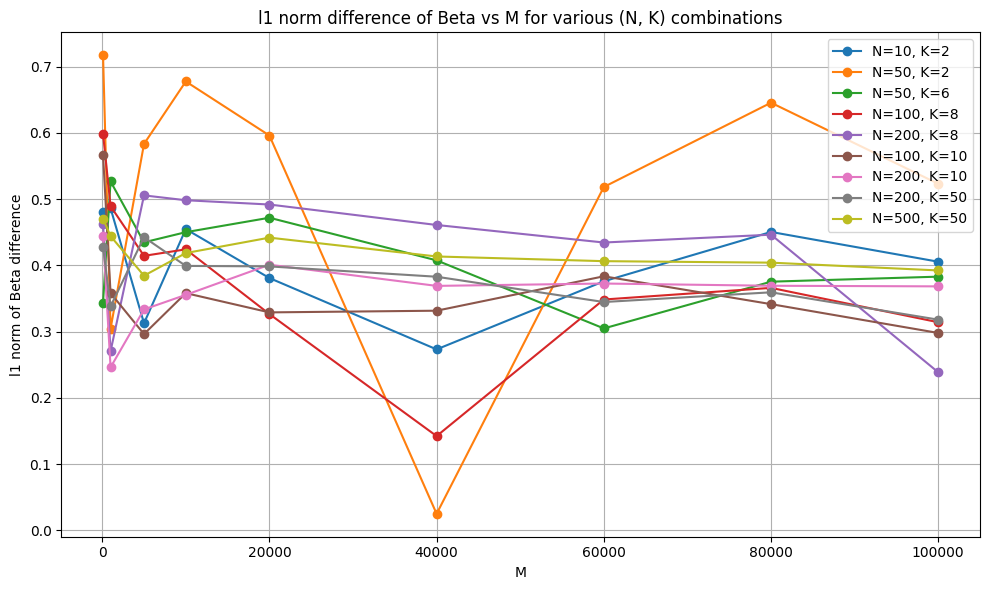

In [24]:
import matplotlib.pyplot as plt
import numpy as np  # needed for squaring the RMSE values

M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]

plt.figure(figsize=(10, 6))

for n, k in zip(N_array, K_array):
    key = f"{n}_{k}"
    l1_values = l1_beta_array_dict.get(key)
    if l1_values is not None:
#         mse_values = [v**2 for v in rmse_values]  # square RMSE to get MSE
        plt.plot(M_array, l1_values, marker='o', label=f"N={n}, K={k}")
    else:
        print(f"Warning: No RMSE values found for key {key}")

plt.xlabel("M")
plt.ylabel("l1 norm of Beta difference")
plt.title("l1 norm difference of Beta vs M for various (N, K) combinations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

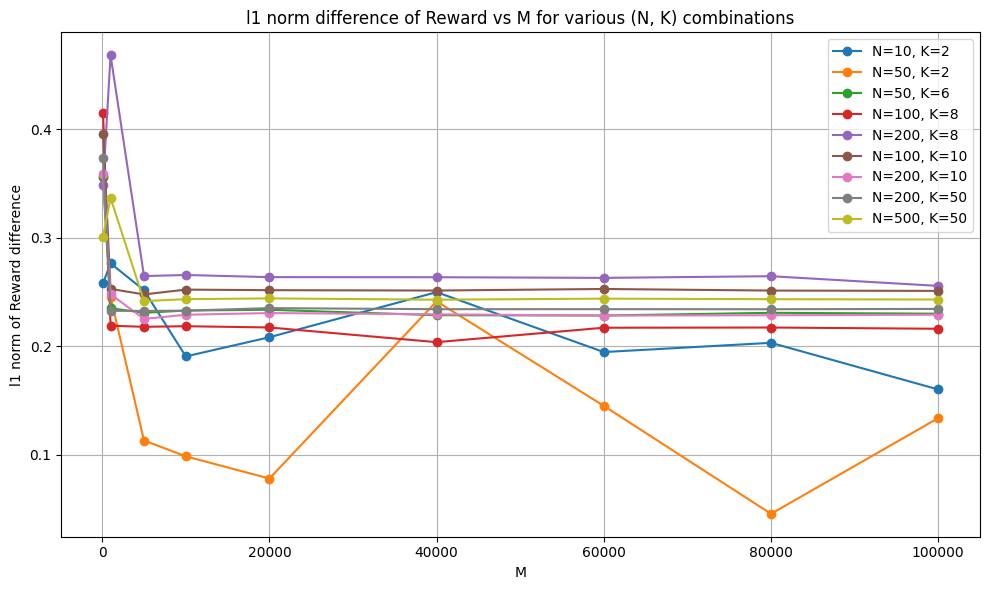

In [27]:
import matplotlib.pyplot as plt
import numpy as np  # needed for squaring the RMSE values

M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]

plt.figure(figsize=(10, 6))

for n, k in zip(N_array, K_array):
    key = f"{n}_{k}"
    l1_values = l1_r_array_dict.get(key)
    if l1_values is not None:
#         mse_values = [v**2 for v in rmse_values]  # square RMSE to get MSE
        plt.plot(M_array, l1_values, marker='o', label=f"N={n}, K={k}")
    else:
        print(f"Warning: No RMSE values found for key {key}")

plt.xlabel("M")
plt.ylabel("l1 norm of Reward difference")
plt.title("l1 norm difference of Reward vs M for various (N, K) combinations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
scores_dict["50_6"]["our"]

KeyError: '50_6'

In [ ]:
import matplotlib.pyplot as plt

M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
N_array = [10, 50, 50, 100, 200, 100, 200, 200, 500]
K_array = [2, 2, 6, 8, 8, 10, 10, 50, 50]

for N, K in zip(N_array, K_array):
    key = f"{N}_{K}"
    acc = scores_dict[key]["our"]
    original_acc = scores_dict[key]["original"]

    plt.figure(figsize=(8, 5))
    plt.plot(M_array, acc, marker='o', label='EM (ours)')
    plt.plot(M_array, original_acc, marker='x', linestyle='--', label='Original')
    
    plt.xlabel("Number of comparisons (m)")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. m for N={N}, K={K}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

M_array = [100, 1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000]
N_array = [10, 50, 50, 200, 200, 500]
K_array = [2, 2, 6, 10, 50, 50]

plt.figure(figsize=(12, 7))

i = 0
for N, K in zip(N_array, K_array):
    key = f"{N}_{K}"
    acc = scores_dict[key]["our"]
    original_acc = scores_dict[key]["original"]

    label_em = f"EM: N={N}, K={K}"
    label_orig = f"Original"
    
    plt.plot(M_array, acc, marker='o', label=label_em)
    if i == 0:
        plt.plot(M_array, original_acc, marker='x', linestyle='--', label=label_orig)
        i = i + 1
    else:
        plt.plot(M_array, original_acc, marker='x', linestyle='--')

plt.xlabel("Number of comparisons (m)")
plt.ylabel("Accuracy")
# plt.title("Performance of Extended BTL Model on various (N,K) settings")
plt.legend(loc='best', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.savefig("result_line_graph.svg", format="svg")